In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

In [2]:
mnist_train = pd.read_csv('mnist_train.csv')
mnist_test = pd.read_csv('mnist_test.csv')

In [3]:
mnist_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,1x11,1x12,1x13,1x14,1x15,1x16,1x17,1x18,1x19,1x20,1x21,1x22,1x23,1x24,1x25,1x26,1x27,1x28,2x1,2x2,2x3,2x4,2x5,2x6,2x7,2x8,2x9,2x10,2x11,...,27x17,27x18,27x19,27x20,27x21,27x22,27x23,27x24,27x25,27x26,27x27,27x28,28x1,28x2,28x3,28x4,28x5,28x6,28x7,28x8,28x9,28x10,28x11,28x12,28x13,28x14,28x15,28x16,28x17,28x18,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,147,252,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
mnist_train.dropna(inplace=True)
mnist_test.dropna(inplace=True)

Image Batch shape: torch.Size([8, 28, 28])


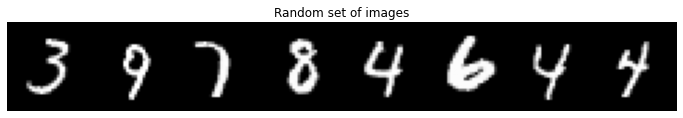

In [5]:
# Show a random set of images
random_sel = mnist_train.sample(8)
image_features = random_sel.drop('label', axis=1)
image_batch = (torch.Tensor(image_features.values / 255.)).reshape((-1, 28, 28))
print(f'Image Batch shape: {image_batch.shape}')
grid = torchvision.utils.make_grid(image_batch.unsqueeze(1), nrow=8)

plt.figure(figsize=(12, 12))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title('Random set of images')
plt.show();

In [6]:
X_train = mnist_train.drop(columns='label').values
y_train = mnist_train['label'].values

X_test = mnist_test.drop(columns='label').values
y_test = mnist_test['label'].values

In [7]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape

(torch.Size([60000, 784]),
 torch.Size([10000, 784]),
 torch.Size([60000]),
 torch.Size([10000]))

In [8]:
X_train_tensor = X_train_tensor.reshape(-1, 1, 28, 28) # (N, c, w, h)
X_test_tensor = X_test_tensor.reshape(-1, 1, 28, 28)
X_train_tensor.shape, X_test_tensor.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([10000, 1, 28, 28]))

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
CHANNELS = 1
HIDDEN = [16, 32]
OUTPUT = 10
KERNEL = 5

In [12]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(CHANNELS, HIDDEN[0], KERNEL),
        nn.BatchNorm2d(HIDDEN[0]),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(HIDDEN[0], HIDDEN[1], KERNEL),
        nn.BatchNorm2d(HIDDEN[1]),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.fc = nn.Linear(512, OUTPUT)

  def forward(self, x):
    out = self.layer1(x)
    print(out.shape)

    out = self.layer2(out)
    print(out.shape)

    out = out.reshape(out.size(0), -1)
    print(out.shape)

    out = self.fc(out)
    print(out.shape)

    return out

In [14]:
model = ConvNet()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda:0


ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [15]:
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [16]:
LEARNING_RATE = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
EPOCHS=10
losses = []
for epoch in range(1, EPOCHS + 1):
  outputs = model(X_train_tensor)
  loss = criterion(outputs, y_train_tensor)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  print(f'Epoch: {epoch}, loss: {loss.item():.4f}')
  losses.append(loss.item())

torch.Size([60000, 16, 12, 12])
torch.Size([60000, 32, 4, 4])
torch.Size([60000, 512])
torch.Size([60000, 10])
Epoch: 1, loss: 2.3385
torch.Size([60000, 16, 12, 12])
torch.Size([60000, 32, 4, 4])
torch.Size([60000, 512])
torch.Size([60000, 10])
Epoch: 2, loss: 2.0340
torch.Size([60000, 16, 12, 12])
torch.Size([60000, 32, 4, 4])
torch.Size([60000, 512])
torch.Size([60000, 10])
Epoch: 3, loss: 1.8097
torch.Size([60000, 16, 12, 12])
torch.Size([60000, 32, 4, 4])
torch.Size([60000, 512])
torch.Size([60000, 10])
Epoch: 4, loss: 1.6277
torch.Size([60000, 16, 12, 12])
torch.Size([60000, 32, 4, 4])
torch.Size([60000, 512])
torch.Size([60000, 10])
Epoch: 5, loss: 1.4678
torch.Size([60000, 16, 12, 12])
torch.Size([60000, 32, 4, 4])
torch.Size([60000, 512])
torch.Size([60000, 10])
Epoch: 6, loss: 1.3285
torch.Size([60000, 16, 12, 12])
torch.Size([60000, 32, 4, 4])
torch.Size([60000, 512])
torch.Size([60000, 10])
Epoch: 7, loss: 1.2099
torch.Size([60000, 16, 12, 12])
torch.Size([60000, 32, 4, 4])


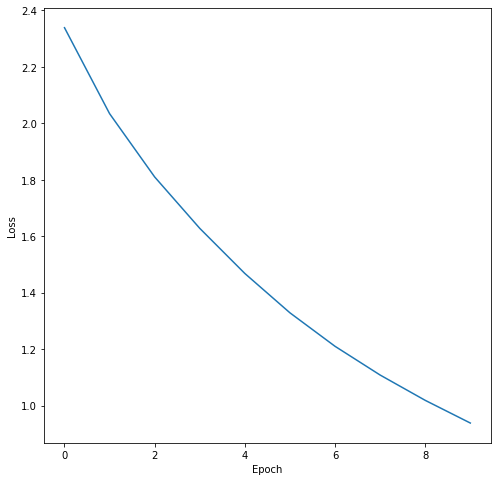

In [18]:
x = range(len(losses))

plt.figure(figsize=(8,8))
plt.plot(x, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss');

In [20]:
model.eval()
from sklearn.metrics import accuracy_score, precision_score, recall_score
with torch.no_grad():

  correct = 0
  total = 0

  outputs = model(X_test_tensor)
  _, preds = torch.max(outputs.data, 1)

  y_test = y_test_tensor.cpu().numpy()
  preds = preds.cpu()

  print(f'Accuracy: {accuracy_score(preds, y_test)}')
  print(f'Precision: {precision_score(preds, y_test, average="weighted")}')
  print(f'Recall: {recall_score(preds, y_test, average="weighted")}')


torch.Size([10000, 16, 12, 12])
torch.Size([10000, 32, 4, 4])
torch.Size([10000, 512])
torch.Size([10000, 10])
Accuracy: 0.7841
Precision: 0.8218729091370376
Recall: 0.7841
